In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

# Deep Learning Model

Now we are going to build upon the current data we built up until now, to build a deep learning model.

This has to be an end-to-end model that can be used to detect fake news.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from transformers import RobertaTokenizer, RobertaModel
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
class CustomDataset(Dataset):
    def __init__(self, df, text_column, num_features, label_column, tokenizer, max_length=245):
        self.df = df
        self.texts = df[text_column].values
        self.numerical_features = df[num_features].values
        self.labels = df[label_column].values
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.num_features = num_features

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.texts[idx]
        numerical_features = torch.tensor(self.numerical_features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'numerical_features': numerical_features,
            'label': label
        }

In [6]:
class RobertaTextNumericalModel(pl.LightningModule):
    def __init__(self, num_features, n_classes=2):
        super(RobertaTextNumericalModel, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.drop = nn.Dropout(p=0.3)
        self.text_embedding_dim = self.roberta.config.hidden_size
        self.num_features = len(num_features)
        self.fc1 = nn.Linear(self.text_embedding_dim + self.num_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, numerical_features):
        roberta_output = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = roberta_output.pooler_output
        x = torch.cat((pooled_output, numerical_features), dim=1)
        x = self.drop(torch.relu(self.fc1(x)))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        numerical_features = batch['numerical_features']
        labels = batch['label']

        outputs = self(input_ids, attention_mask, numerical_features)
        loss = self.criterion(outputs, labels)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        numerical_features = batch['numerical_features']
        labels = batch['label']

        outputs = self(input_ids, attention_mask, numerical_features)
        loss = self.criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=2e-5)


In [7]:
df_roberta = pd.read_csv(f"/kaggle/input/articles-csv/elaborated_data.csv")

train_val_df = df_roberta[df_roberta['date'] < '2017-09']
test_df = df_roberta[df_roberta['date'] >= '2017-09']

X_train, X_val, y_train, y_val = train_test_split(
    train_val_df.drop(columns=['label', 'date']),
    train_val_df['label'],
    test_size=0.2,
    random_state=42,
    stratify=train_val_df['subject']
)

numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['subject']
text_features = 'text'

X_test = test_df.drop(columns=['label', 'title', 'date'])
y_test = test_df['label']

In [8]:
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

scaler = StandardScaler()
train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])
val_df[numerical_features] = scaler.transform(val_df[numerical_features])
test_df[numerical_features] = scaler.transform(test_df[numerical_features])

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_dataset = CustomDataset(train_df, text_column='text', num_features=numerical_features, label_column='label', tokenizer=tokenizer)
val_dataset = CustomDataset(val_df, text_column='text', num_features=numerical_features, label_column='label', tokenizer=tokenizer)
test_dataset = CustomDataset(test_df, text_column='text', num_features=numerical_features, label_column='label', tokenizer=tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [9]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=True,
    mode='min'
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='best_model',
    save_top_k=1,
    mode='min'
)

model = RobertaTextNumericalModel(num_features=numerical_features)

trainer = pl.Trainer(
    max_epochs=50,
    devices=1,
    callbacks=[early_stopping_callback, checkpoint_callback]
)

trainer.fit(model, train_loader, val_loader)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [10]:
print(f"Best checkpoint saved at: {checkpoint_callback.best_model_path}")

Best checkpoint saved at: /kaggle/working/checkpoints/best_model.ckpt


In [11]:
from pytorch_lightning.utilities.model_summary import ModelSummary

print(ModelSummary(model, max_depth=-1))

    | Name                                                      | Type                 | Params | Mode 
-------------------------------------------------------------------------------------------------------------
0   | roberta                                                   | RobertaModel         | 124 M  | eval 
1   | roberta.embeddings                                        | RobertaEmbeddings    | 39.0 M | eval 
2   | roberta.embeddings.word_embeddings                        | Embedding            | 38.6 M | eval 
3   | roberta.embeddings.position_embeddings                    | Embedding            | 394 K  | eval 
4   | roberta.embeddings.token_type_embeddings                  | Embedding            | 768    | eval 
5   | roberta.embeddings.LayerNorm                              | LayerNorm            | 1.5 K  | eval 
6   | roberta.embeddings.dropout                                | Dropout              | 0      | eval 
7   | roberta.encoder                                     

Accuracy: 0.9774
Precision: 0.9798
Recall: 0.9774
F1 Score: 0.9779

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     11716
           1       0.88      0.99      0.93      2245

    accuracy                           0.98     13961
   macro avg       0.94      0.98      0.96     13961
weighted avg       0.98      0.98      0.98     13961



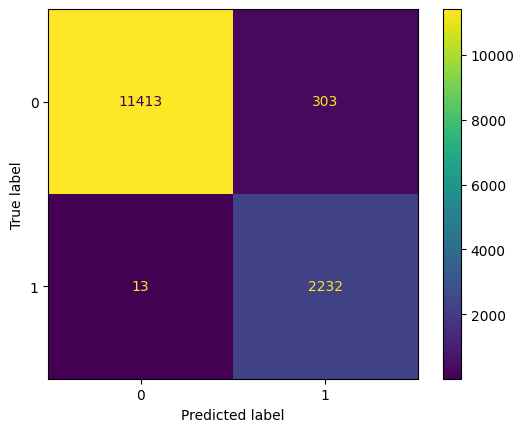

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

model.eval()

predictions = []
true_labels = []
probabilities = []
misclassified_indices = []
misclassified_texts = []

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        numerical_features = batch['numerical_features']
        labels = batch['label']
        
        outputs = model(input_ids, attention_mask, numerical_features)
        
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy()) 
        true_labels.extend(labels.cpu().numpy()) 
        
        probs = torch.softmax(outputs, dim=1)
        probabilities.extend(probs.cpu().numpy())
        
        misclassified_batch_indices = (preds != labels).nonzero(as_tuple=True)[0]
        misclassified_indices.extend(misclassified_batch_indices + len(predictions) - len(preds))
        misclassified_texts.extend(input_ids[misclassified_batch_indices].cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)
probabilities = np.array(probabilities)

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(true_labels, predictions))

ConfusionMatrixDisplay.from_predictions(true_labels, predictions)
plt.show()

AUC Score: 0.9980


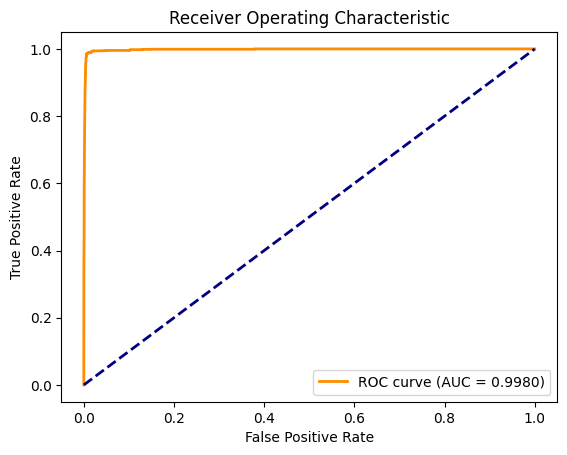

In [13]:
if len(np.unique(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probabilities[:, 1])
    print(f"AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("AUC Score is only applicable for binary classification.")

In [14]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
print("\nExamples of Misclassified Items:")
for idx, input_ids in zip(misclassified_indices[:5], misclassified_texts[:5]):
    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
    true_label = true_labels[idx]
    predicted_label = predictions[idx]
    print(f"Index: {idx}, True Label: {true_label}, Predicted Label: {predicted_label}")
    print(f"Text: {decoded_text}")
    print("-" * 80)


Examples of Misclassified Items:
Index: 51, True Label: 0, Predicted Label: 1
Text: when uzbek writer nurulloh muhammad raufkhon s new book came out last year security forces raided his home and put the author who was in turkey at the time on their blacklist effectively forcing him to stay there in exile now after being removed from the list by the new government the year old raufkhon plans to return to his central asian homeland despite harboring some misgivings a safe return of prominent dissidents such as raufkhon might herald a genuine thaw in uzbekistan and mark a significant step toward restoring ties with the west and attracting foreign investment after decades of political and economic near isolation under the late president islam karimov no prominent dissidents have returned home yet though since karimov died a year ago and raufkhon said some of his fellow emigres were still unconvinced it was safe to do so raufkhon s book entitled bu kunlar these days was a critique of uzbek